In [ ]:
'''
# https://www.kalmanfilter.net/alphabeta.html
# Estimate the state of a static system

# Estimate current state
# Predict the next state
'''

import numpy as np
import matplotlib.pyplot as plt
import random
import math
'''
# State Update Equation (estimate of the current state)
# Estimate = Predicted value + kalmangain(measurement - predicted value)
#xEst = xPrev + (1/t)(z-xPrev)

# Estimation Algorithm 
# 0. Initialize - Input: System State and Initial Guess
# 1. Measure - Input: Measured Value
# 2. Update - Calculate the kalman gain then estimate the current state using the state update equation
# Output system state estimate
# 3. Predict -  Calculate the predicted state for the next iteration using the system's dynamic model
'''


In [ ]:
# Example 1: Static State
# Estimating the weight of a gold bar that we know weighs 1000kg 

# True state
x = 1000

# Initial Guess at t=0. initial = x because its not supposed to change
initial = x

# Measured value of the weight at t
z = None

# 1/t calculated each iteration
statemodel = None

# xhat-1
xPrev = None

# Because this example is static, we don't expect it to change
xPrev = initial

# xhat
xEst = None

iterations = 100

plt.axis([0, iterations, x-500, x+500])

for t in range(1, iterations):
    # Weigh and measure
    z = np.random.normal(x, x/2, 1)

    xEst = xPrev + (1/t) * (z - xPrev) 
    xPrev = xEst
    
    plt.scatter(t, x, color="tab:green")
    plt.scatter(t, xEst, color="tab:red")
    plt.scatter(t, z, color="tab:blue")
    
    # Print only the first and last few iterations
    if t < 15 or t > iterations-5:
        print(f"{t}: Est x: {xEst} Error: {(abs(xEst-x)/x)*100}% Measurement err:{(abs(z-x)/x)*100}% ")

plt.show()

In [ ]:
'''
Example 2 - Tracking the Constant Velocity Aircraft in 1D

Aircraft moving away from a radar orthogonally at constant velocity
radar -------> plane

Aircraft state: xdot = v = dx/dt



Prediction Equations (2nd of the 5 KF equations)

xEst = xPrev + xdotPrev*deltaT

and

xdotEst = xdotPrev

because the velocity is constant



Scenario Constants:

deltaT = 5 sec
xPrev = 30,000 m
xdotPrev = 40 m/s

Plugging this into the prediction equations we can predict the position at time t

xEst = 30,000 + 40*5 = 30,200 m
and
xdotEst = 40 m/s

But when we actually measure at time t, the radar measures z = 30,110 m 

There is two possiblities for this:
1. The radar measurement was not precise
2. The aircraft velocity changed and is now (z-xPrev)/deltaT = 22 m/s

Which is true?

Well let's keep measuring it and see.



The velocity state update equation is:
xdotEst = xdotPrev + B * ((z-xEst)/deltaT)

So we can adjust the confidence of the radar based on it's precision using the B value.
If it's really inprecise we should set B low at like 0.1 and if it's really precise set it like 0.9

The B is gonna adjust influence of the amount the current measurement has on the xdot estimate


The position state update equation is:
xEst = xPrev + a * (z - xPrev)

Unlike the previous example, the a parameter is constant
For a really precise radar, a should be high like 0.9. 
If a is 1, then xEst = xPrev + 1 * (z - xPrev) = z which means the measured range = estimate range
If a = 0 then the measurement has no impact


So together we have the state update equation for the radar. Also called the a-b track (update|filtering) equations.

Position:
xEst = xPrev + a * (z - xPrev)
Velocity:
xdotEst = xdotPrev + b * ((z - xPrev)/deltaT)

State Extrapolation Equation:
xEst = xdot + xdotEst*deltaT
xdotEst = xdotPrev because we don't expect it to change

Later, the Kalman Gain will replace the a-b parameters in the Kalman Filter and it is updated every iteration
a-b parameters affect the convergence rate and need to be tuned to converge within a good amount of iterations
'''

iterations = 100
rPrecision = 25

# Ground truth
x = 30000
xDot = 40

xEst = x # given but generally not given/known
xdotEst = xDot # given but generally not given/known
deltaT = 5

a = 0.1
b = 0.05

# Initial Guess
xNext = xEst + deltaT * xdotEst
xdotNext = xdotEst

#plt.axis([0, iterations, x-1000, x+xDot*deltaT * iterations])
plt.axis([0, iterations, xDot-10, xDot+10])

for t in range(1, iterations, 1):
    #print(f"{t}: xdotEst: {xdotEst} Error: {(abs(xdotEst-xDot)/xDot)*100}%")
    x = x + xDot*deltaT
    z = np.random.normal(x, rPrecision, 1)
    
    #plt.scatter(t, x, color="tab:green")
    #plt.scatter(t, xEst, color="tab:red")
    #plt.scatter(t, z, color="tab:blue")
    
    plt.scatter(t, xDot, color="tab:green")
    plt.scatter(t, xdotEst, color="tab:red")
    

    # State Update
    xNext = xEst + a * (z - xEst)
    xdotNext = xdotEst + b * ((z-xEst)/deltaT)
    
    # State Extrapolation
    xEst = xNext + xdotEst*deltaT
    xdotEst = xdotNext
    
    #plt.scatter(t, xNext, color="tab:grey")
    
    
plt.scatter(t, xDot, color="tab:green", label="actual")
plt.scatter(t, xdotEst, color="tab:red", label="estimate")
plt.legend(loc="upper left")

plt.show()

![ex3image](https://www.kalmanfilter.net/img/AlphaBeta/ex3_acceleratedMovement.png)

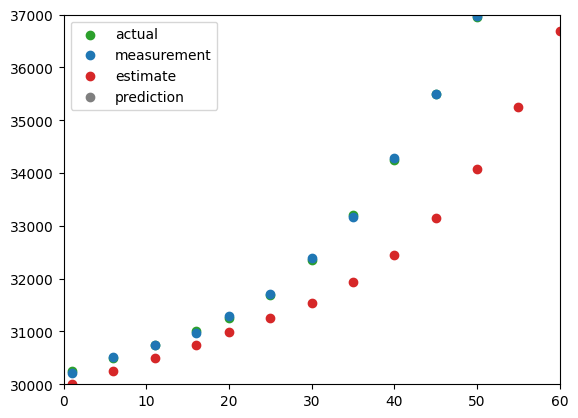

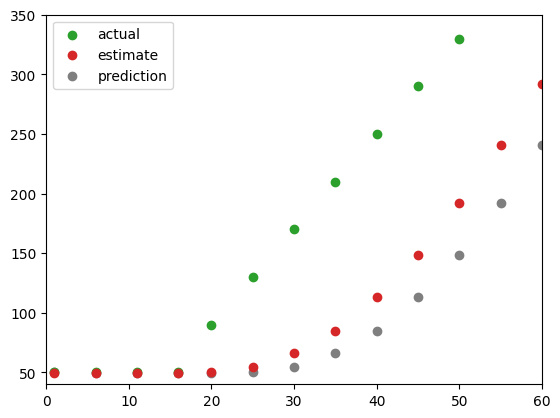

In [139]:
'''
Example 3 - Tracking Constant Accelerating Aircraft in 1-D

Aircraft moves at a constant xDot = 50m/s for 20 sec, then constantly accelerates 8m/s^2 for 35 seconds

Same equations as last example

As you can see with the plots below, this filter is pretty bad. It lags behind during acceleration
'''
rPrecision = 50
dt = 5

# Ground truth
x = 30000
xDot = 50
xDotDot = 0

xEst = x # given but generally not given/known
xDotEst = xDot # given but generally not given/known

a = 0.2
b = 0.1

# Initial Guess
xNextEst = xEst + dt * xDotEst
xDotNextEst = xDotEst

xplot = plt.figure()
vplot = plt.figure()

xx = xplot.add_subplot()
vx = vplot.add_subplot()

xx.axis([0, 60, 30000, 37000])
vx.axis([0, 60, 40, 350])

for t in range(1, 20, 5):
    x = x + xDot*dt
    z = np.random.normal(x, rPrecision, 1)
    
    xx.scatter(t, x, color="tab:green")
    xx.scatter(t, xEst, color="tab:red")
    xx.scatter(t, z, color="tab:blue") 
    xx.scatter(t, xNext, color="tab:grey")

    vx.scatter(t, xDotNextEst, color="tab:grey")
    
    # State Update
    xEst = xNextEst + a * (z - xNextEst)
    xDotEst = xDotNextEst + b * ((z-xNextEst)/dt)
    
    # State Extrapolation
    xNextEst = xEst + xDotEst*dt
    xDotNextEst = xDotEst

    vx.scatter(t, xDot, color="tab:green")
    vx.scatter(t, xDotEst, color="tab:red")

xDotDot = 8

for t in range(20, 70, 5):
    x = x + xDot*dt
    xDot = xDot + xDotDot * dt # Accelerating
    z = np.random.normal(x, rPrecision, 1)
    
    xx.scatter(t, x, color="tab:green")
    xx.scatter(t, xEst, color="tab:red")
    xx.scatter(t, z, color="tab:blue")
    xx.scatter(t, xNext, color="tab:grey")
    
    vx.scatter(t, xDotNextEst, color="tab:grey")

    # State Update
    xEst = xNextEst + a * (z - xNextEst)
    xDotEst = xDotNextEst + b * ((z-xNextEst)/dt)
    
    # State Extrapolation
    xNextEst = xEst + xDotEst*dt
    xDotNextEst = xDotEst

    vx.scatter(t, xDot, color="tab:green")
    vx.scatter(t, xDotEst, color="tab:red")
    
xx.scatter(t, x, color="tab:green", label="actual")
xx.scatter(t, z, color="tab:blue", label="measurement")
xx.scatter(t, xEst, color="tab:red", label="estimate")
xx.scatter(t, xNext, color="tab:grey", label="prediction")
xx.legend(loc="upper left")

vx.scatter(t, xDot, color="tab:green", label="actual")
vx.scatter(t, xDotEst, color="tab:red", label="estimate")
vx.scatter(t, xDotNextEst, color="tab:grey", label="prediction")
vx.legend(loc="upper left")

plt.show()

In [ ]:
'''
Example 3 - Tracking Constant Accelerating Aircraft in 1-D

Aircraft moves at a constant xDot = 50m/s for 20 sec, then constantly accelerates 8m/s^2 for 35 seconds

Same equations as last example

As you can see with the plots below, this filter is pretty bad. It lags behind during acceleration
'''
rPrecision = 25
dt = 1
a = 0.2
b = 0.1

# Ground truth
x = 30000
xDot = 50

xEst = x # given but generally not given/known
xDotEst = xDot # given but generally not given/known

# Initial Guess
xNextEst = xEst + dt * xDotEst
xDotNextEst = xDotEst

xPrevEst = 0
xDotPrevEst = 0

xplot = plt.figure()
vplot = plt.figure()

xx = xplot.add_subplot()
vx = vplot.add_subplot()

xx.axis([0, 60, 30000, 37000])
vx.axis([0, 60, 40, 350])

for t in range(1, 20, 5):
    x = x + xDot*dt
    xx.scatter(t, x, color="tab:green")
    xx.scatter(t, xEst, color="tab:red")
    xx.scatter(t, z, color="tab:blue")
    
    vx.scatter(t, xDot, color="tab:green")
    vx.scatter(t, xdotEst, color="tab:red")
    
    # Initial Guess
    #xEst = xNextEst
    #xDotEst = xDotNextEst
    
    # Measurement
    z = np.random.normal(x, rPrecision, 1)

    # State Update
    xEst = xNextEst + a * (z - xNextEst)
    xDotEst = xDotNextEst + b * ((z-xNextEst)/dt)
    
    # State Extrapolation
    xNextEst = xEst + xDotEst*dt
    xDotNextEst = xDotEst

    xx.scatter(t, xNext, color="tab:grey")

for t in range(20, 70, 5):
    x = x + xDot*dt
    xx.scatter(t, x, color="tab:green")
    xx.scatter(t, xEst, color="tab:red")
    xx.scatter(t, z, color="tab:blue")
    
    vx.scatter(t, xDot, color="tab:green")
    vx.scatter(t, xdotEst, color="tab:red")
    
    # Initial Guess
    #xEst = xNextEst
    #xDotEst = xDotNextEst
    
    # Measurement
    z = np.random.normal(x, rPrecision, 1)

    # State Update
    xEst = xNextEst + a * (z - xNextEst)
    xDotEst = xDotNextEst + b * ((z-xNextEst)/dt)
    
    # State Extrapolation
    xNextEst = xEst + xDotEst*dt
    xDotNextEst = xDotEst

    xDot = xDot + dt * 8

    xx.scatter(t, xNext, color="tab:grey")


xx.scatter(t, x, color="tab:green", label="actual")
xx.scatter(t, z, color="tab:blue", label="measurement")
xx.scatter(t, xEst, color="tab:red", label="estimate")
xx.scatter(t, xNext, color="tab:grey", label="prediction")
xx.legend(loc="upper left")

vx.scatter(t, xDot, color="tab:green", label="actual")
vx.scatter(t, xdotEst, color="tab:red", label="estimate")
vx.scatter(t, xdotNext, color="tab:grey", label="prediction")
vx.legend(loc="upper left")

plt.show()

In [ ]:
'''
Example 4 - Tracking Constant Accelerating Aircraft in 1-D with a-b-γ filter

Aircraft moves at a constant xDot = 50m/s for 20 sec, then constantly accelerates 8m/s^2 for 35 seconds

The a-b-y filter adds another state extrapolation equation and another state update equation for the acceleration

'''
rPrecision = 50
deltaT = 5

a = 0.5
b = 0.4
y = 0.1

# Ground truth
x = 30000
xDot = 50
xDotDot = 0 # this changes to 8 m/s^2 at t=20

xEst = x # given but generally not given/known
xdotEst = xDot # given but generally not given/known
xdotdotEst = 0

# Initial State Extrapolation
xNext = xEst + (deltaT * xdotEst) + xdotdotEst*((deltaT*deltaT)/2)
xdotNext = xdotEst + (deltaT * xdotdotEst)
xdotdotNext = xdotdotEst

xplot = plt.figure()
vplot = plt.figure()
aplot = plt.figure()

xx = xplot.add_subplot()
vx = vplot.add_subplot()
ax = aplot.add_subplot()

xx.axis([0, 60, 30000, 37000])
vx.axis([0, 60, 40, 350])
ax.axis([0, 60, 40, 350])

for t in range(1, 20, 5):
    x = x + xDot*deltaT
    z = np.random.normal(x, rPrecision, 1)

    xEst = xNext
    xdotEst = xdotNext
    xdotdotEst = xdotdotNext
 
    xx.scatter(t, x, color="tab:green")
    xx.scatter(t, xEst, color="tab:red")
    xx.scatter(t, z, color="tab:blue")
    
    vx.scatter(t, xDot, color="tab:green")
    vx.scatter(t, xdotEst, color="tab:red")
    
    # State Update
    xNext = xEst + a * (z - xEst)
    xdotNext = xdotEst + b * ((z-xEst)/deltaT)
    xdotdotNext = xdotdotEst + y * ((z-xEst)/((deltaT*deltaT)/2))
    
    # State Extrapolation
    xNext = xEst + (deltaT * xdotEst) + xdotdotEst*(deltaT*deltaT)/2
    xdotNext = xdotEst + (deltaT * xdotdotEst)
    xdotdotNext = xdotdotEst
    
    xx.scatter(t, xNext, color="tab:grey")

xDotDot = 8

for t in range(20, 70, 5):
    x = x + xDot*deltaT
    z = np.random.normal(x, rPrecision, 1)
    
    xx.scatter(t, x, color="tab:green")
    xx.scatter(t, xEst, color="tab:red")
    xx.scatter(t, z, color="tab:blue")
    
    vx.scatter(t, xDot, color="tab:green")
    vx.scatter(t, xdotEst, color="tab:red")

    # State Update
    xNext = xEst + a * (z - xEst)
    xdotNext = xdotEst + b * ((z-xEst)/deltaT)
    xdotdotNext = xdotdotEst + y * ((z-xEst)/((deltaT*deltaT)/2))
    
    # State Extrapolation
    xEst = xEst + (deltaT * xdotEst) + xdotdotEst*(deltaT*deltaT)/2
    xdotEst = xdotEst + (deltaT * xdotdotEst)
    xdotdotEst = xdotdotEst

    xDot = xDot + xDotDot*deltaT
    
    vx.scatter(t, xdotNext, color="tab:grey")
    print(f"{xdotEst}, {xdotdotEst}")


xx.scatter(t, x, color="tab:green", label="actual")
xx.scatter(t, z, color="tab:blue", label="measurement")
xx.scatter(t, xEst, color="tab:red", label="estimate")
xx.scatter(t, xNext, color="tab:grey", label="prediction")
xx.legend(loc="upper left")

vx.scatter(t, xDot, color="tab:green", label="actual")
vx.scatter(t, xdotEst, color="tab:red", label="estimate")
vx.scatter(t, xdotNext, color="tab:grey", label="prediction")
vx.legend(loc="upper left")

plt.show()